# Components

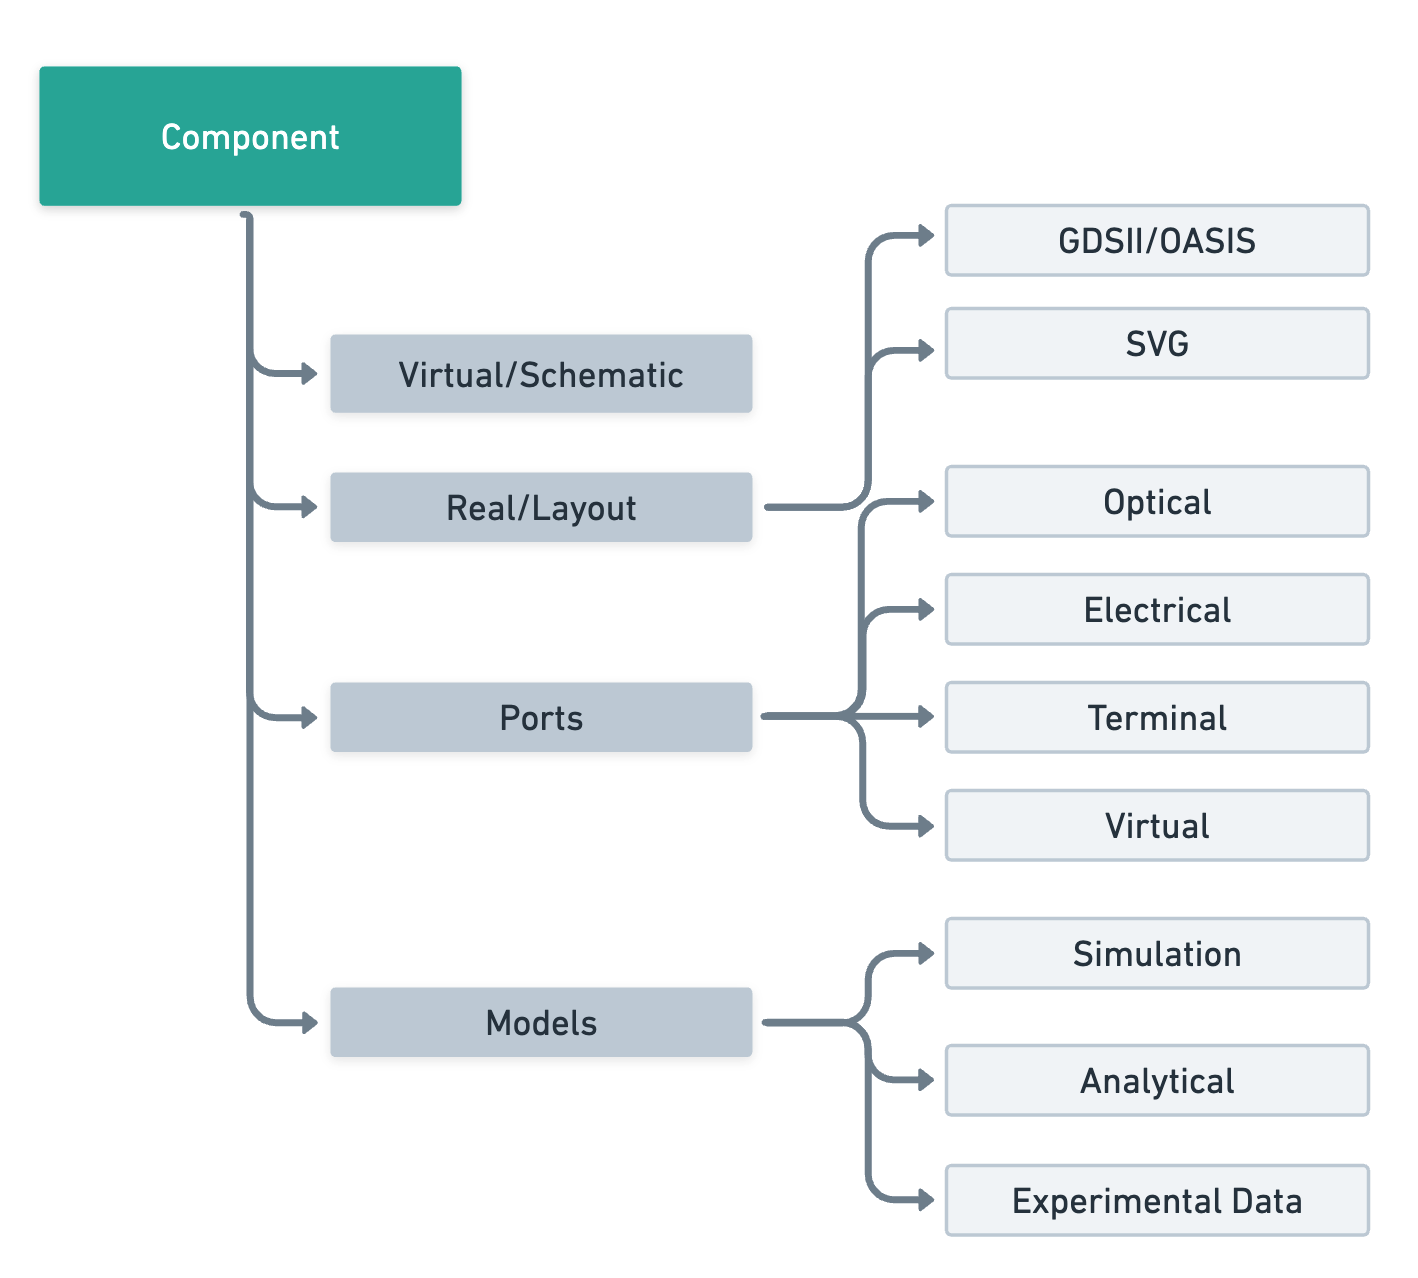

A [Component](../_autosummary/photonforge.Component.rst) in PhotonForge is like an empty canvas that holds geometric shapes (like rectangles, circles, and polygons), ports (optical or electrical interfaces), models (Tidy3D models, circuit models, waveguide models, data models, and analytical models), and references to other components.

This modular structure simplifies the creation of hierarchical layouts and promotes reuse of subcomponents.

In PhotonForge, all **dimensions are in microns**, and the layout can be visualized directly within the notebook or exported as GDS files.


In [1]:
import photonforge as pf
from photonforge.live_viewer import LiveViewer
viewer = LiveViewer(port=5000) 
import siepic_forge as siepic

# Set the default technology for this project from the PDK library
pf.config.default_technology = siepic.ebeam()

Starting live viewer at http://localhost:5000


## Drawing a Polygon (Basic Taper Example)

Let’s define a simple polygon that mimics a waveguide taper—a structure used to transition smoothly from a narrow waveguide to a wider one. Although we're manually creating this polygon, PhotonForge provides a built-in **[transition function](../_autosummary/photonforge.parametric.transition.rst)** for generating tapers automatically.

Waveguide tapers are fundamental building blocks in photonic circuits, helping reduce mode-mismatch losses when connecting waveguides of different widths or guiding modes between different photonic components.

In [2]:
c = pf.Component("taper_demo")

# Coordinates of a simple taper-shaped polygon (narrow to wide waveguide)
# Taper from width 0.5 µm to 2 µm over 10 µm
polygon = pf.Polygon([(0, -0.25), (0, 0.25), (10, 1.0), (10, -1.0)])
c.add((1, 0),polygon)
c

### Adding Text Labels 

In PhotonForge, you can conveniently add text labels to your layouts to clearly annotate components or indicate fabrication notes. It’s also straightforward to position elements precisely using offsets. For example, labeling specific structures like waveguides, grating couplers, or alignment marks becomes intuitive and clear.

In this example, we'll create a simple rectangular waveguide and label it clearly with a text annotation. We'll also demonstrate using offset positioning.


In [3]:
from photonforge.stencil import as_component

# 1. Create a blank parent component
c = pf.Component("text_offset_demo")

# 2. Create a reusable text component via stencil API
text_comp = as_component(
    layer=(10, 0),
    stencil="text",
    text_string="Waveguide Section",
    size=1.0,               # text height in microns
)

# 3. Create a simple rectangle component (e.g., a waveguide)
rect_comp = pf.Component("waveguide")
rect_shape = pf.Rectangle(size=(10, 1))
rect_comp.add((1,0),rect_shape)

# 4. Add references of both components into the parent
rect_ref   = pf.Reference(rect_comp)
text_ref1  = pf.Reference(text_comp)
text_ref2  = pf.Reference(text_comp)

c.add_reference(rect_ref)
c.add_reference(text_ref1)
c.add_reference(text_ref2)

# 5. Position the references with translations and a rotation
#    - Center waveguide at origin
#    - Label above the waveguide
#    - A second label offset and rotated for demonstration
rect_ref.translate((0, 0))
text_ref1.translate((0, 1.5))     # 1.5 μm above
text_ref2.translate((5, 1.5))     # 5 μm to the right, 1.5 μm up
text_ref2.rotate(45)              # rotate label by 45°

# 6. Inspect or export
c.write_gds()


### Offsetting a Polygon

PhotonForge can offset any polygon to create enlarged or contracted copies. This is useful for generating buffer regions, cladding outlines, or general shape expansions.

Below, we define a simple taper-like polygon and offset it by 2 µm.


In [4]:
# 1. Create a blank component
c = pf.Component("offset_demo")

# 2. Define a polygon shape
poly = pf.Polygon([(0, 0), (5, 1), (10, 1), (10, -1), (5, -1)])

# 3. Add the original polygon on layer (1,0)
c.add((1, 0), poly)

# 4. Offset the polygon by 2 µm
offset_shapes = pf.offset(poly, distance=2.0)

# 5. Add the offset shapes on layer (2,0)
for shape in offset_shapes:
    c.add((2, 0), shape)

# 6. View the result
c


**Boolean Difference Between Shapes**

You can perform boolean operations between polygons. Here, we subtract the original polygon from its offset copy to get the “ring” or margin region.


In [5]:
# 1. Compute the difference: offset minus original
margin_shapes = pf.boolean(offset_shapes, poly, operation="-")

# 2. Add the resulting margin on layer (3,0)
for shape in margin_shapes:
    c.add((3, 0), shape)

# 3. View the result
c


**Extracting Boolean Results into a Separate Component**

For modularity, you may want to isolate the boolean result into its own component. This makes it easy to export or manipulate that region independently.


In [6]:
# 1. Create a new component for the margin region
margin_comp = pf.Component("margin_only")

# 2. Add each margin polygon on layer (3,0)
for shape in margin_shapes:
    margin_comp.add((3, 0), shape)

# 3. View the isolated margin component
margin_comp


## References
### Connecting Ports

Components can have “ports” that let you snap Component `Reference`s together, just like LEGO bricks. Here we:

1. Create three straight segments via the `straight` parametric function.  
2. Position them with simple translations and rotations.  
3. Connect them by matching port names.

Each straight segment provides two ports, named **P0** (left side) and **P1** (right side).


In [7]:
from photonforge.parametric import straight

# 1. Create a blank component
c = pf.Component("port_connection_demo")

# 2. Create three straight segments
wg1 = pf.Reference(straight(port_spec="TE_1550_500", length=2.0))
c.add_reference(wg1)

wg2 = pf.Reference(straight(port_spec="TE_1550_500", length=3.0))
wg2.translate((0, 10))
wg2.rotate(10)
c.add_reference(wg2)

wg3 = pf.Reference(straight(port_spec="TE_1550_500", length=5.0))
wg3.translate((0, 20))
wg3.rotate(15)
c.add_reference(wg3)

c


In [8]:
# 3. Connect segments by matching ports
wg2.connect("P1", wg1["P0"])
wg3.connect("P1", wg2["P0"])

c

**Exposing Top-Level Ports**

You can promote child ports to the parent component’s interface by adding them directly. This makes your new component ready to be used (or connected) elsewhere.


In [9]:
# 4. Expose wg1’s input (P1) and wg3’s output (P0) on the top-level component
c.add_port(wg1["P1"])
c.add_port(wg3["P0"])

# View the final component with its exposed ports
c

### Moving and Rotating

PhotonForge lets you translate, rotate, and mirror component references with simple attribute assignments and transformation methods. All coordinates are in microns (floating-point), so you position instances by:

- Setting reference properties (e.g., `x_min`, `x_max`, `y_mid`).  
- Calling `.translate()`, `.rotate()`, or `.mirror()`.  


In [10]:
# 1. Create a blank component
c = pf.Component("instance_transform_demo")

# 2. Create three straight segments of varying lengths
wg1 = pf.Reference(straight(port_spec="TE_1550_500", length=1.0))
c.add_reference(wg1)

wg2 = pf.Reference(straight(port_spec="TE_1550_500", length=2.0))
c.add_reference(wg2)

wg3 = pf.Reference(straight(port_spec="TE_1550_500", length=3.0))
c.add_reference(wg3)

# 3. Position segments using attribute assignment (microns)
wg2.x_min = wg1.x_max          # place wg2 immediately after wg1
wg3.x_min = wg2.x_max + 1.0    # leave a 1 µm gap before wg3

# 4. Rotate the third segment for demonstration
wg3.rotate(30)                 # rotate wg3 by 30 degrees

# 5. View the arranged instances
c

### Move Reference by Port

PhotonForge can automatically translate and rotate a reference so that one of its ports aligns exactly with a target port on another reference. This “move by port” feature makes it trivial to snap bends, splitters, or any parametric element directly onto existing ports.


In [11]:
from photonforge.parametric import bend

# 1. Create the top-level component
c = pf.Component("move_by_port_demo")

# 2. Generate an MMI component via stencil API
mmi_comp = as_component(
    stencil="mmi",
    layer=(1, 0),
    length=6.0,         # MMI length in µm
    width=2.0,          # MMI width in µm
    num_ports=(1, 2),   # 1 input on one side, 2 outputs on the other
    port_length=10.0,
    port_width=0.5,
    tapered_width=0.8,
)
# Detect and add its ports
mmi_comp.add_port(mmi_comp.detect_ports(["TE_1550_500"]))

mmi_ref = pf.Reference(mmi_comp)
c.add_reference(mmi_ref)

# 3. Create a 90° bend
bend_comp = bend(
    port_spec="TE_1550_500",
    radius=5.0,
    angle=90.0,
)
bend_ref = pf.Reference(bend_comp)
c.add_reference(bend_ref)

# 4. View initial placement
c

In [12]:
# Connect the bend’s input port "P0" to the MMI’s second output port "P2"
bend_ref.connect("P0", mmi_ref["P2"])
c

In [13]:
# Mirror the bend about the component origin and reconnect its port
bend_ref.mirror()
bend_ref.connect("P0", mmi_ref["P2"])
c

## Labels

PhotonForge lets you place labels at arbitrary coordinates or at locations derived from component references and overall layout bounds. In this example, we:

1. Create a new parent component.  
2. Add existing waveguide references (`wg1`, `wg2`) into it.  
3. Add labels at each reference’s center.  
4. Compute the component’s bounding box and annotate its width.

These labels will display in a GDS viewer, but will not be rendered or printed like the `text` polygons.


In [14]:
from photonforge import Label

# 1. Create a fresh component
c2 = pf.Component("demo_with_labels")

# 2. Add the existing references (e.g., wg1 and wg2) into c2
mwg1_ref = c2.add_reference(wg1)
mwg2_ref = c2.add_reference(wg2)

# 3. Place text labels at each reference center
c2.add(
    Label(
        text="First label",
        origin=(mwg1_ref.x_mid, mwg1_ref.y_mid)
    )
)
c2.add(
    Label(
        text="Second label",
        origin=(mwg2_ref.x_mid, mwg2_ref.y_mid)
    )
)

# 4. Measure the overall width of c2 and annotate it
(x_min, y_min), (x_max, y_max) = c2.bounds()
width = x_max - x_min
c2.add(
    Label(
        text=f"The layout width is {width:.2f} µm",
        origin=(x_min, y_min)
    )
)

# 5. View the result 
c2.write_gds()


**Simple Label on a Rectangle Reference**

You can also label arbitrary points or origins. Here we:

1. Create a small rectangle component.  
2. Place it in a new parent.  
3. Add a label at (0, 0).
   
To control the label's alignment, we use the `anchor` property. This property specifies which part of the text's bounding box should be placed at the `origin` coordinate.

By setting the anchor to `'SW'` (South-West), we align the **bottom-left corner** of the text with the origin. This contrasts with the default anchor, `'NW'` (North-West), which aligns the **top-left corner**.

In [15]:
# 1. Parent component
c = pf.Component("demo_simple_label")

# 2. Create and add a 1×1 µm rectangle on layer (1,0)
rect = pf.Component("rect")
rect.add((1, 0), pf.Rectangle(size=(1, 1)))
r = c.add_reference(rect)

# 3. Position the rectangle at the origin
r.x_min = 0
r.y_min = 0

# 4. Add a label at (0,0), anchor point ('SW') is the bottom-left corner 
c.add(Label(text="Demo label", origin=(0, 0), anchor='SW'))

# 5. View the labeled rectangle
c.write_gds()


## Boolean Operations on Shapes

PhotonForge can perform set operations—union, intersection, difference, and symmetric difference (XOR)—on polygons and circles. The `boolean()` function supports these operations via the `operation` argument, which can be one of:

- `"+"` (union)  
- `"^"` (symmetric difference)  
- `"-"` (difference)  
- `"*"` (intersection)  



In [16]:
from photonforge import Circle

# 1. Create a component to hold the shapes
c = pf.Component("boolean_demo")

# 2. Define three overlapping ellipses
e1 = Circle(radius=(10, 5))
e2 = Circle(radius=(10, 6)).translate((2, 0))
e3 = Circle(radius=(10, 4)).translate((5, 0))

# 3. Add them all on layer (1,0)
c.add((1, 0), e1, e2, e3)

# 4. View the raw shapes
viewer(c)


**Difference: Subtract One Shape from Another**

Here we subtract `e1` from `e2` to get their overlap region removed from the larger ellipse.


In [17]:
# 1. Compute the difference e2 minus e1
diff_shapes = pf.boolean(e2, e1, operation="-")

# 2. Create a new component for the result
c_diff = pf.Component("boolean_difference")

# 3. Add the difference shapes on layer (2,0)
for shape in diff_shapes:
    c_diff.add((2, 0), shape)

# 4. View the subtraction result
viewer(c_diff)


**Union and XOR Examples**

You can also merge shapes or take their symmetric difference:

- **Union (A+B):** merges all areas  
- **XOR:** keeps regions where exactly one shape exists  


In [18]:
# Union of e1 and e3
union_shapes = pf.boolean(e1, e3, operation="+")
c_union = pf.Component("boolean_union")
for shape in union_shapes:
    c_union.add((3, 0), shape)
viewer(c_union)

In [19]:
# XOR of e1 and e3
xor_shapes = pf.boolean(e1, e3, operation="^")
c_xor = pf.Component("boolean_xor")
for shape in xor_shapes:
    c_xor.add((4, 0), shape)
viewer(c_xor)

## Writing and Visualizing

PhotonForge supports exporting components to multiple formats like **GDS (.gds)** and **OASIS (.oas)** for chip fabrication.

Beyond file export, PhotonForge can integrate Tidy3D FDTD models and visualize electromagnetic fields or 3D extrusions directly within your notebook.


In [20]:
# 1. Create a component and a simple cross shape via the stencil API
c = pf.Component("export_demo")
cross_poly = pf.stencil.cross(6.0, 0.5)
c.add((1, 0), cross_poly)

# 2. Detect and expose any optical ports
c.add_port(c.detect_ports(["TE_1550_500"]))

# 3. Write and view as GDS
c.write_gds("export_demo.gds")

OASIS is a more compact format for CAD layouts, reducing file size compared to GDS.

In [21]:
c.write_oas("demo.oas")

### Visualization with Tidy3D

PhotonForge integrates seamlessly with Tidy3D for quick electromagnetic simulation and visualization.


<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

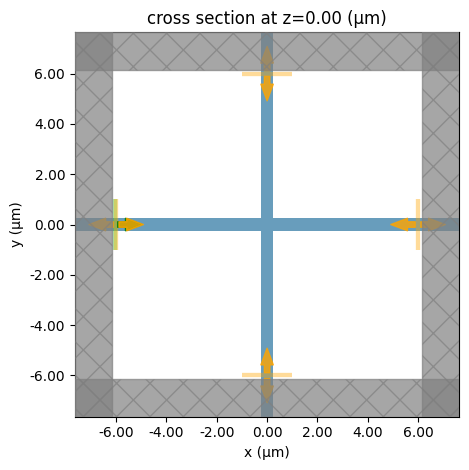

In [22]:
# Plot a 2D cross section at z=0
pf.tidy3d_plot(c, z=0)



You can extrude any 2D shape into 3D and send it to Tidy3D for simulation and visualization.


<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

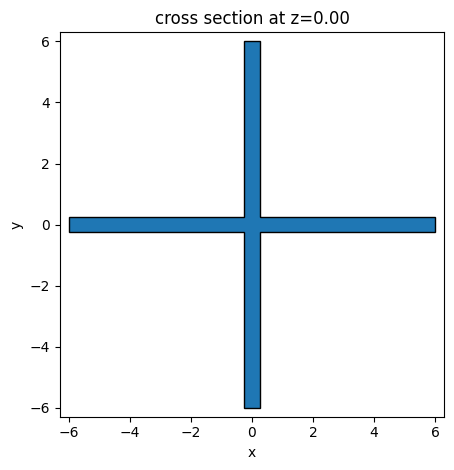

In [23]:
import tidy3d as td
extruded = pf.Extruded(
    td.Medium(permittivity=1.5), cross_poly, (-0.5, 0.5)
)
extruded.to_tidy3d().plot(z=0)